In [1]:
from transformers.trainer_utils import get_last_checkpoint
from transformers import (
    Trainer,
    TrainingArguments,
    Wav2Vec2CTCTokenizer,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
    trainer_utils,
)
from model import Wav2Vec2ForCTCnCLS

from dataclasses import dataclass, field
from typing import Any, Callable, Dict, List, Optional, Set, Union
from arguments import ModelArguments, DataTrainingArguments

import yaml
import os
import random

import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# For reproducibility
SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [3]:
yaml_file = "reproduce.yaml"
# yaml_file = "train.yaml"
# yaml_file = "predict.yaml"

# Read configuration file with all the necessary parameters
with open(yaml_file) as file:
    config = yaml.safe_load(file)

Retrieve arguments from the respective yaml file.

In [4]:
# Arguments
model_args = ModelArguments(**config['model_args'])
data_args = DataTrainingArguments(**config['data_args'])
training_args = TrainingArguments(**config['training_args'])

Load preprocessed datasets and processor from disk.

In [5]:
# SPLIT_ID identifies the test split
SPLIT_ID = data_args.split_id 

if data_args.load_reduced:
    train_path = f"./datasets/reduced_train_ds/{SPLIT_ID}"
    val_path = f"./datasets/reduced_val_ds/{SPLIT_ID}"
    
else:
    train_path = f"./datasets/prepared_train_ds/{SPLIT_ID}"
    val_path = f"./datasets/prepared_val_ds/{SPLIT_ID}"

prepared_train_dataset = datasets.load_from_disk(train_path)
prepared_val_dataset = datasets.load_from_disk(val_path)
processor = Wav2Vec2Processor.from_pretrained("datasets/processor")

cls_label_map = {"e0":0, "e1":1, "e2":2, "e3":3}

Emotion Classes:
- e0: Neutral
- e1: Happy
- e2: Angry
- e3: Sad

In [7]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for processing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None
    audio_only = False

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        
        if self.audio_only is False: # Training
            label_features = [{"input_ids": feature["labels"][:-1]} for feature in features]
            # Class label is the last element in the feature list
            cls_labels = [feature["labels"][-1] for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        if self.audio_only is False:
            with self.processor.as_target_processor():
                labels_batch = self.processor.pad(
                    label_features,
                    padding=self.padding,
                    max_length=self.max_length_labels,
                    pad_to_multiple_of=self.pad_to_multiple_of_labels,
                    return_tensors="pt",
                )

            # Replace padding with -100 to ignore loss correctly
            ctc_labels = labels_batch["input_ids"].masked_fill_(labels_batch.attention_mask.ne(1), -100)
            batch["labels"] = (ctc_labels, torch.tensor(cls_labels)) # labels = (ctc_labels, cls_labels)

        return batch

In [8]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
wer_metric = datasets.load_metric("wer")

**Word error rate** (**WER**) is used as performance metric for the speech recognition task.

It consists in measuring the difference, in terms of character edits (insertions, deletions or substitutions), between two sequences, i.e., the predicted text and the actual text.

$$
{\displaystyle {\mathit {WER}}={\frac {S+D+I}{N}}={\frac {S+D+I}{S+D+C}}}
$$

where:

- *S* is the number of substitutions,
- *D* is the number of deletions, 
- *I* is the number of insertions,
- *C* is the number of correct words,
- *N* is the number of words in the reference (N=S+D+C)

The **lower** the value, the **better** the performance of the ASR system.

In [9]:
def compute_metrics(pred):
    # Emotion labels predictions
    cls_pred_logits = pred.predictions[1]
    cls_pred_ids = np.argmax(cls_pred_logits, axis=-1)
    total = len(pred.label_ids[1])
    correct = (cls_pred_ids == pred.label_ids[1]).sum().item() # label = (ctc_label, cls_label)

    # Transcript predictions
    ctc_pred_logits = pred.predictions[0]
    ctc_pred_ids = np.argmax(ctc_pred_logits, axis=-1)
    pred.label_ids[0][pred.label_ids[0] == -100] = processor.tokenizer.pad_token_id

    # WER operates on string, hence we have to decode the ids
    ctc_pred_str = processor.batch_decode(ctc_pred_ids)
    # We do not want to group tokens when computing the metrics
    ctc_label_str = processor.batch_decode(pred.label_ids[0], group_tokens=False)
    
    wer = wer_metric.compute(predictions=ctc_pred_str, references=ctc_label_str)
    return {"acc": correct/total, "wer": wer, "correct": correct, "total": total, "strlen": len(ctc_label_str)}


## Model

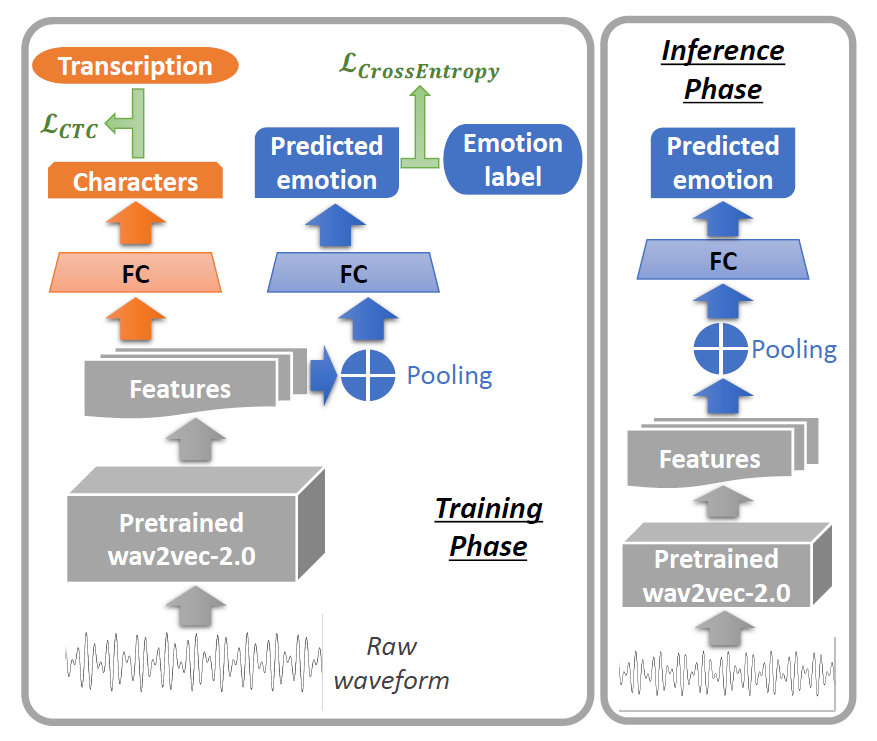

The <span style="color:orange">**orange**</span> part correponds to the ASR (**A**utomatic **S**peech **R**ecognition) task: it **inputs** speech features and **outputs** text.

The <span style="color:blue">**blue**</span> part corresponds to the SER (**S**peech **E**motion **R**ecognition) task: it **inputs** speech features and **outputs** emotion labels.

The **loss** is composed by two losses:
- The CTC loss for the transcriptions:
    - $\mathcal{L}_{CTC} = CTC(\hat{y}, t)$, where $\hat{y}$ are the text predictions.
- The Cross-entropy loss for the emotion labels:
    - $\mathcal{L}_{CE} = CrossEntropy(\hat{c}, t)$, where $\hat{c}$ are the predicted labels

The $\alpha$ hyper-parameter combines the two losses and controls the relative importance of the CTC loss of the ASR task.

$\mathcal{L} = \mathcal{L}_{CE} + \alpha\mathcal{L}_{CTC}$
    

In [10]:
model = Wav2Vec2ForCTCnCLS.from_pretrained(
        model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
        gradient_checkpointing=training_args.gradient_checkpointing,
        vocab_size=len(processor.tokenizer),
        cls_len=len(cls_label_map),
        alpha=model_args.alpha,
    )

Some weights of the model checkpoint at ckpts/02F were not used when initializing Wav2Vec2ForCTCnCLS: ['vib_ctc.emb2mu.bias', 'vib_ctc.std_p', 'vib_cls.emb2std.bias', 'vib_cls.emb2std.weight', 'vib_cls.classifier.bias', 'vib_cls.mu_p', 'vib_ctc.emb2std.bias', 'vib_cls.mlp.0.bias', 'vib_ctc.classifier.bias', 'vib_cls.mlp.2.weight', 'vib_ctc.emb2std.weight', 'vib_cls.classifier.weight', 'vib_ctc.mlp.0.bias', 'vib_cls.emb2mu.bias', 'vib_ctc.mlp.2.bias', 'vib_ctc.mlp.0.weight', 'vib_ctc.mlp.2.weight', 'vib_cls.emb2mu.weight', 'vib_ctc.classifier.weight', 'vib_ctc.mu_p', 'vib_cls.mlp.0.weight', 'vib_cls.mlp.2.bias', 'vib_ctc.emb2mu.weight', 'vib_cls.std_p']
- This IS expected if you are initializing Wav2Vec2ForCTCnCLS from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTCnCLS from the checkpoint of a model that 

In [11]:
class CTCTrainer(Trainer):
    def _prepare_inputs(self, inputs: Dict[str, Union[torch.Tensor, Any]]) -> Dict[str, Union[torch.Tensor, Any]]:
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                kwargs = dict(device=self.args.device)
                if self.deepspeed and inputs[k].dtype != torch.int64:
                    kwargs.update(dict(dtype=self.args.hf_deepspeed_config.dtype()))
                inputs[k] = v.to(**kwargs)

            if k == 'labels': # labels are list of tensor, not tensor, special handle here
                for i in range(len(inputs[k])):
                    kwargs = dict(device=self.args.device)
                    if self.deepspeed and inputs[k][i].dtype != torch.int64:
                        kwargs.update(dict(dtype=self.args.hf_deepspeed_config.dtype()))
                    inputs[k][i] = inputs[k][i].to(**kwargs)

        if self.args.past_index >= 0 and self._past is not None:
            inputs["mems"] = self._past

        return inputs

    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)
        
        if self.use_amp:
            if "cuda" in self.args.device.type:
                with torch.autocast("cuda"):
                    loss = self.compute_loss(model, inputs)
            else:
                with torch.autocast("cpu"):
                    loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.n_gpu > 1:
            loss = loss.mean()

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()

In [12]:
trainer = CTCTrainer(
        model=model,
        data_collator=data_collator,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=prepared_train_dataset,
        eval_dataset=prepared_val_dataset,
        tokenizer=processor.feature_extractor,
    )

Using amp half precision backend


In [13]:
# Make sure that the learning rate is read as a number and not as a string
training_args.learning_rate = float(training_args.learning_rate)
training_args.learning_rate

0.1

In [14]:
# Detecting last checkpoint
last_checkpoint = None
if os.path.isdir(training_args.output_dir) and not training_args.overwrite_output_dir:
    last_checkpoint = get_last_checkpoint(training_args.output_dir)
    if last_checkpoint is None and len(os.listdir(training_args.output_dir)) > 0:
        raise ValueError(
            f"Output directory ({training_args.output_dir}) already exists and is not empty. "
            "Use --overwrite_output_dir to overcome."
        )
    elif last_checkpoint is not None:
        print(
            f"Checkpoint detected, resuming training at {last_checkpoint}. To avoid this behavior, change "
            "the `--output_dir` or add `--overwrite_output_dir` to train from scratch."
        )

In [15]:
if last_checkpoint is not None:
    checkpoint = last_checkpoint
elif model_args.model_name_or_path is not None and os.path.isdir(model_args.model_name_or_path):
    checkpoint = model_args.model_name_or_path
else:
    checkpoint = None

In [16]:
if training_args.do_train:
    trainer.train(resume_from_checkpoint=checkpoint)
    trainer.save_model() 

In [17]:
def write_predictions(dataset: datasets.arrow_dataset.Dataset, pred_ids: np.ndarray, pred_probs: torch.tensor):
    # Write predictions to a file
    with open(data_args.output_file, 'w') as f:
        f.write("Wav File\t Duration\t Emotion Class\t Probabilities\n")
        for i in range(len(pred_ids)):
            wav_file = dataset[i]['file'].split("/")[-1]
            duration = str(len(dataset[i]['input_values'])/16000)
            f.write(wav_file+ " " + duration + " ")
            pred = pred_ids[i]
            f.write(str(pred)+' ')
            for j in range(4):
                f.write(' ' + str(pred_probs[i][j].item()))
            f.write('\n')

In [18]:
if training_args.do_predict:
    print('******* Predict ********')
    data_collator.audio_only=True
    # In predictions we do not have the labels 
    predictions, _ , metrics = trainer.predict(prepared_val_dataset, metric_key_prefix="predict")
    logits_ctc, logits_cls = predictions
    pred_ids = np.argmax(logits_cls, axis=-1)
    pred_probs = F.softmax(torch.from_numpy(logits_cls).float(), dim=-1)

    # Write predictions to a file
    if 'file' in prepared_val_dataset.column_names:
        write_predictions(prepared_val_dataset, pred_ids, pred_probs)
    

elif training_args.do_eval:
    predictions, labels, metrics = trainer.predict(prepared_val_dataset, metric_key_prefix="eval")
    logits_ctc, logits_cls = predictions
    pred_ids = np.argmax(logits_cls, axis=-1)
    correct = np.sum(pred_ids == labels[1])
    acc = correct / len(pred_ids)
    print('correct:', correct, ', acc:', acc)



***** Running Prediction *****
  Num examples = 505
  Batch size = 1


correct: 418 , acc: 0.8277227722772277
